In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

# Extracting the dataset
Extracting all mask images from the dataset and seperated the data set in the following categories:
1-train
2-mask

In [2]:
train_data = []
mask_data = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_data:
    train_data.append(i.replace('_mask',''))

In [25]:
df = pd.DataFrame(data={"filename": train_data, 'mask' : mask_data})
dframe_train, dframe_test = train_test_split(df,test_size = 0.1)
dframe_train, dframe_val = train_test_split(dframe_train,test_size = 0.2)
print(dframe_train.values.shape)
print(dframe_val.values.shape)
print(dframe_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


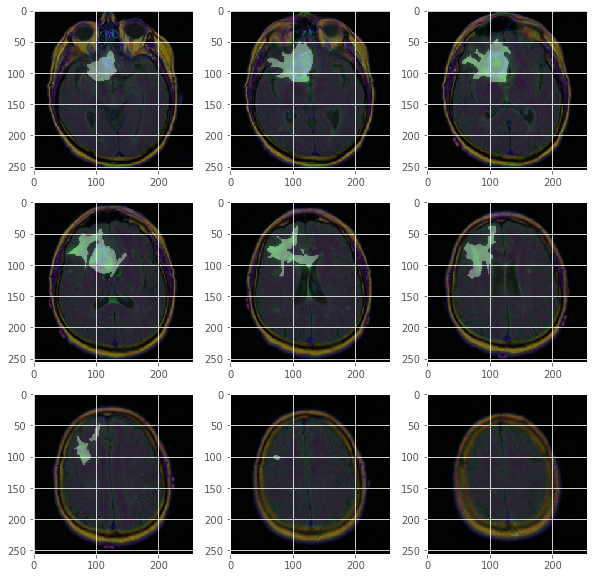

In [4]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_data[i]
    msk_path=mask_data[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.3)
plt.show()

# Data Augmentation for Segmentation 
The difference with data augmentation during segmentaion is that when we 
rotate an input image by 90 degrees to produve a transformed input we also need
to rotate the output of segmentations(masks) by 90 degrees to get our transformed 
output segmentation.<br>
Using the same seed for both the image_datagen and mask_datagen will ensure that the transormation for both of them is the same.<br>
Here is the implementation of train generator for segmentation task.

In [5]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
   
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# Loss Function
The Dice coefficient is a loss function for segmentation models.<br>
The following functions are implementation of Dice Loss and IoU (Intersection over Union).<br>
The goal of using IoU is to evaluate how similar our predicted bounding box is to the ground truth bounding box.<br>
### Dice coefficient formula
<img src="dice_coef.png">

In [6]:
smooth=100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

In [7]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def iou_func(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [9]:
def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou_func(y_true, y_pred)

# U-Net Architecture

In [10]:
def unet_arch(input_size=(256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)
    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)
    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)
    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)
    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)
    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)
    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)
    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
model = unet_arch()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [14]:
EPOCHS = 150
BATCH_SIZE = 16
learning_rate = 1e-4

# Training The Model

In [15]:
image_width = 256
image_height = 256
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(dframe_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(image_height, image_width))
    
test_gener = train_generator(dframe_val, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))
    
model = unet_arch(input_size=(image_height, image_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou_func, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(dframe_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(dframe_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
  ...
    to  
  ['...']
Found 708 validated image filenames.
Found 708 validated image filenames.
  ...
    to  
  ['...']
Train for 176.75 steps, validate for 44.25 steps
Epoch 1/150
176/176 [============================>.] - ETA: 0s - loss: -0.1427 - binary_accuracy: 0.9495 - iou_func: 0.0793 - dice_coef: 0.1427
Epoch 00001: val_loss improved from inf to -0.02828, saving model to unet_brain_mri_seg.hdf5
177/176 [==============================] - 126s 714ms/step - loss: -0.1431 - binary_accuracy: 0.9497 - iou_func: 0.0795 - dice_coef: 0.1431 - val_loss: -0.0283 - val_binary_accuracy: 0.9886 - val_iou_func: 0.0144 - val_dice_coef: 0.0278
Epoch 2/150
176/176 [============================>.] - ETA: 0s - loss: -0.2357 - binary_accuracy: 0.9871 - iou_func: 0.1389 - dice_coef: 0.2357
Epoch 00002: val_loss improved from -0.02828 to -0.13674, saving model to unet_brain_mri_seg.hdf5
177/176 [==========================

Epoch 18/150
176/176 [============================>.] - ETA: 0s - loss: -0.7957 - binary_accuracy: 0.9967 - iou_func: 0.6757 - dice_coef: 0.7957
Epoch 00018: val_loss did not improve from -0.83853
177/176 [==============================] - 116s 657ms/step - loss: -0.7944 - binary_accuracy: 0.9967 - iou_func: 0.6742 - dice_coef: 0.7944 - val_loss: -0.5984 - val_binary_accuracy: 0.9933 - val_iou_func: 0.4448 - val_dice_coef: 0.5884
Epoch 19/150
176/176 [============================>.] - ETA: 0s - loss: -0.7887 - binary_accuracy: 0.9966 - iou_func: 0.6695 - dice_coef: 0.7887
Epoch 00019: val_loss improved from -0.83853 to -0.85827, saving model to unet_brain_mri_seg.hdf5
177/176 [==============================] - 119s 670ms/step - loss: -0.7875 - binary_accuracy: 0.9966 - iou_func: 0.6680 - dice_coef: 0.7875 - val_loss: -0.8583 - val_binary_accuracy: 0.9967 - val_iou_func: 0.7352 - val_dice_coef: 0.8440
Epoch 20/150
176/176 [============================>.] - ETA: 0s - loss: -0.8039 - bina

Epoch 37/150
176/176 [============================>.] - ETA: 0s - loss: -0.8443 - binary_accuracy: 0.9973 - iou_func: 0.7447 - dice_coef: 0.8443
Epoch 00037: val_loss did not improve from -0.86923
177/176 [==============================] - 116s 657ms/step - loss: -0.8445 - binary_accuracy: 0.9973 - iou_func: 0.7450 - dice_coef: 0.8445 - val_loss: -0.8117 - val_binary_accuracy: 0.9961 - val_iou_func: 0.6834 - val_dice_coef: 0.7981
Epoch 38/150
176/176 [============================>.] - ETA: 0s - loss: -0.8415 - binary_accuracy: 0.9973 - iou_func: 0.7386 - dice_coef: 0.8415
Epoch 00038: val_loss improved from -0.86923 to -0.87584, saving model to unet_brain_mri_seg.hdf5
177/176 [==============================] - 119s 670ms/step - loss: -0.8413 - binary_accuracy: 0.9973 - iou_func: 0.7384 - dice_coef: 0.8413 - val_loss: -0.8758 - val_binary_accuracy: 0.9970 - val_iou_func: 0.7627 - val_dice_coef: 0.8612
Epoch 39/150
176/176 [============================>.] - ETA: 0s - loss: -0.8600 - bina

Epoch 56/150
176/176 [============================>.] - ETA: 0s - loss: -0.8647 - binary_accuracy: 0.9977 - iou_func: 0.7718 - dice_coef: 0.8647
Epoch 00056: val_loss did not improve from -0.89400
177/176 [==============================] - 116s 657ms/step - loss: -0.8651 - binary_accuracy: 0.9977 - iou_func: 0.7724 - dice_coef: 0.8651 - val_loss: -0.8773 - val_binary_accuracy: 0.9972 - val_iou_func: 0.7743 - val_dice_coef: 0.8627
Epoch 57/150
176/176 [============================>.] - ETA: 0s - loss: -0.8685 - binary_accuracy: 0.9978 - iou_func: 0.7804 - dice_coef: 0.8685
Epoch 00057: val_loss did not improve from -0.89400
177/176 [==============================] - 116s 657ms/step - loss: -0.8686 - binary_accuracy: 0.9978 - iou_func: 0.7805 - dice_coef: 0.8686 - val_loss: -0.8798 - val_binary_accuracy: 0.9973 - val_iou_func: 0.7688 - val_dice_coef: 0.8652
Epoch 58/150
176/176 [============================>.] - ETA: 0s - loss: -0.8733 - binary_accuracy: 0.9978 - iou_func: 0.7849 - dice_

Epoch 75/150
176/176 [============================>.] - ETA: 0s - loss: -0.8633 - binary_accuracy: 0.9977 - iou_func: 0.7711 - dice_coef: 0.8633
Epoch 00075: val_loss did not improve from -0.90141
177/176 [==============================] - 116s 657ms/step - loss: -0.8636 - binary_accuracy: 0.9977 - iou_func: 0.7715 - dice_coef: 0.8636 - val_loss: -0.8871 - val_binary_accuracy: 0.9972 - val_iou_func: 0.7793 - val_dice_coef: 0.8723
Epoch 76/150
176/176 [============================>.] - ETA: 0s - loss: -0.8763 - binary_accuracy: 0.9979 - iou_func: 0.7910 - dice_coef: 0.8763
Epoch 00076: val_loss did not improve from -0.90141
177/176 [==============================] - 116s 657ms/step - loss: -0.8755 - binary_accuracy: 0.9979 - iou_func: 0.7898 - dice_coef: 0.8755 - val_loss: -0.8933 - val_binary_accuracy: 0.9974 - val_iou_func: 0.7897 - val_dice_coef: 0.8784
Epoch 77/150
176/176 [============================>.] - ETA: 0s - loss: -0.8793 - binary_accuracy: 0.9979 - iou_func: 0.7935 - dice_

Epoch 94/150
176/176 [============================>.] - ETA: 0s - loss: -0.8790 - binary_accuracy: 0.9980 - iou_func: 0.7955 - dice_coef: 0.8790
Epoch 00094: val_loss did not improve from -0.90141
177/176 [==============================] - 116s 657ms/step - loss: -0.8787 - binary_accuracy: 0.9980 - iou_func: 0.7950 - dice_coef: 0.8787 - val_loss: -0.8924 - val_binary_accuracy: 0.9972 - val_iou_func: 0.7920 - val_dice_coef: 0.8776
Epoch 95/150
176/176 [============================>.] - ETA: 0s - loss: -0.8871 - binary_accuracy: 0.9980 - iou_func: 0.8045 - dice_coef: 0.8871
Epoch 00095: val_loss improved from -0.90141 to -0.90399, saving model to unet_brain_mri_seg.hdf5
177/176 [==============================] - 118s 669ms/step - loss: -0.8866 - binary_accuracy: 0.9980 - iou_func: 0.8039 - dice_coef: 0.8866 - val_loss: -0.9040 - val_binary_accuracy: 0.9975 - val_iou_func: 0.8046 - val_dice_coef: 0.8889
Epoch 96/150
176/176 [============================>.] - ETA: 0s - loss: -0.8836 - bina

Epoch 113/150
176/176 [============================>.] - ETA: 0s - loss: -0.8902 - binary_accuracy: 0.9981 - iou_func: 0.8097 - dice_coef: 0.8902
Epoch 00113: val_loss did not improve from -0.90820
177/176 [==============================] - 116s 657ms/step - loss: -0.8902 - binary_accuracy: 0.9981 - iou_func: 0.8097 - dice_coef: 0.8902 - val_loss: -0.8884 - val_binary_accuracy: 0.9973 - val_iou_func: 0.7814 - val_dice_coef: 0.8736
Epoch 114/150
176/176 [============================>.] - ETA: 0s - loss: -0.8933 - binary_accuracy: 0.9981 - iou_func: 0.8139 - dice_coef: 0.8933
Epoch 00114: val_loss improved from -0.90820 to -0.91875, saving model to unet_brain_mri_seg.hdf5
177/176 [==============================] - 119s 670ms/step - loss: -0.8934 - binary_accuracy: 0.9981 - iou_func: 0.8142 - dice_coef: 0.8934 - val_loss: -0.9188 - val_binary_accuracy: 0.9978 - val_iou_func: 0.8263 - val_dice_coef: 0.9034
Epoch 115/150
176/176 [============================>.] - ETA: 0s - loss: -0.9106 - b

Epoch 132/150
176/176 [============================>.] - ETA: 0s - loss: -0.9092 - binary_accuracy: 0.9984 - iou_func: 0.8383 - dice_coef: 0.9092
Epoch 00132: val_loss did not improve from -0.92049
177/176 [==============================] - 116s 657ms/step - loss: -0.9092 - binary_accuracy: 0.9984 - iou_func: 0.8383 - dice_coef: 0.9092 - val_loss: -0.9122 - val_binary_accuracy: 0.9979 - val_iou_func: 0.8182 - val_dice_coef: 0.8970
Epoch 133/150
176/176 [============================>.] - ETA: 0s - loss: -0.9047 - binary_accuracy: 0.9984 - iou_func: 0.8316 - dice_coef: 0.9047
Epoch 00133: val_loss did not improve from -0.92049
177/176 [==============================] - 116s 657ms/step - loss: -0.9048 - binary_accuracy: 0.9984 - iou_func: 0.8317 - dice_coef: 0.9048 - val_loss: -0.8841 - val_binary_accuracy: 0.9978 - val_iou_func: 0.7879 - val_dice_coef: 0.8694
Epoch 134/150
176/176 [============================>.] - ETA: 0s - loss: -0.9135 - binary_accuracy: 0.9984 - iou_func: 0.8438 - di

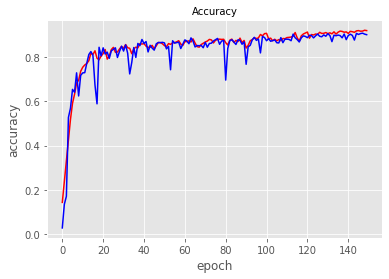

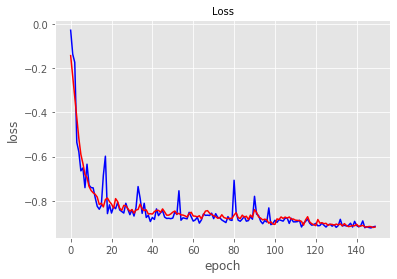

In [19]:
h = history.history
traindice = h['dice_coef']
testdice = h['val_dice_coef']

trainloss = h['loss']
testloss = h['val_loss']

plt.figure(1)
plt.plot(traindice, 'r-')
plt.plot(testdice, 'b-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy', fontsize = 10)

plt.figure(2)
plt.plot(testloss, 'b-')
plt.plot(trainloss,'r-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss', fontsize = 10)
plt.show()

In [30]:
test_gen = train_generator(dframe_test, BATCH_SIZE,
                                dict(),
                                target_size=(image_height, image_width))
results = model.evaluate(test_gen, steps=len(dframe_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
  ...
    to  
  ['...']
25/24 [==============================] - 6s 227ms/step - loss: -0.9145 - binary_accuracy: 0.9985 - iou_func: 0.8465 - dice_coef: 0.9138
Test lost:  -0.9301033408283884
Test IOU:  0.99846494
Test Dice Coefficent:  0.846511


# Visualizing Model's Predictions

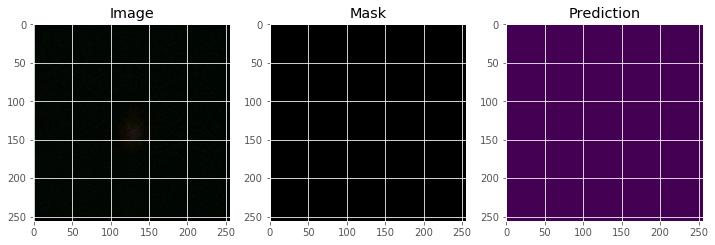

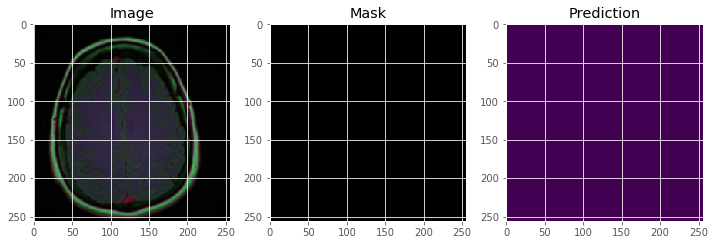

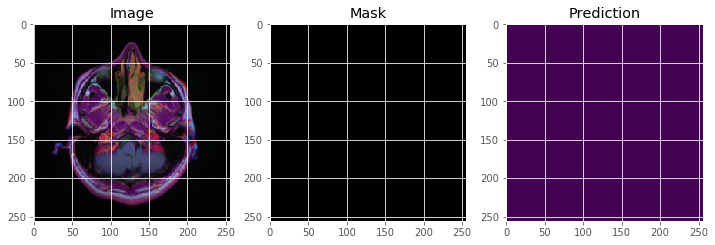

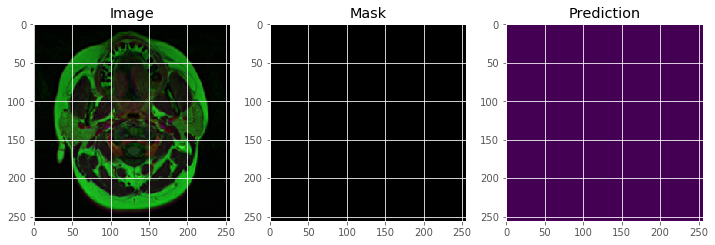

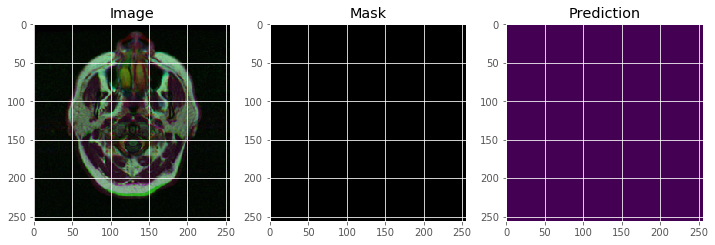

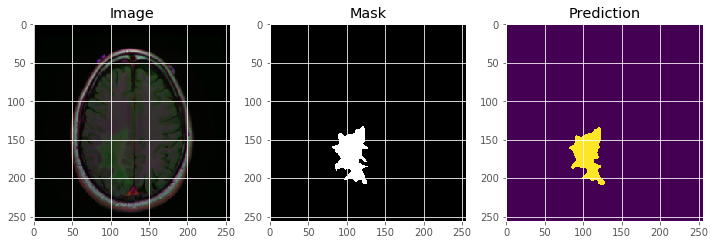

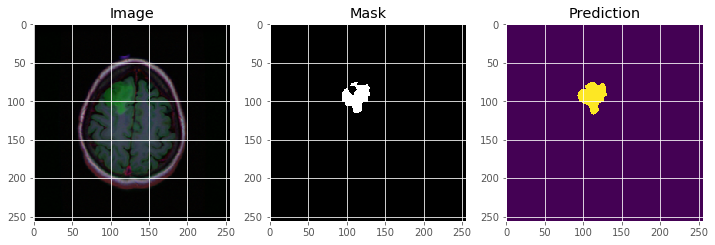

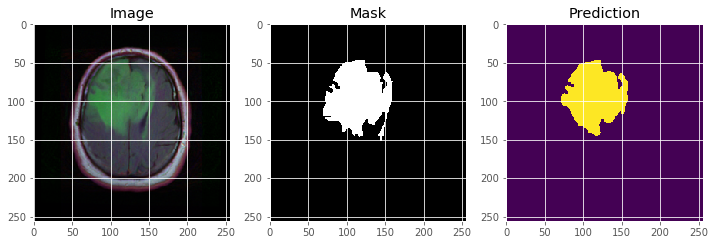

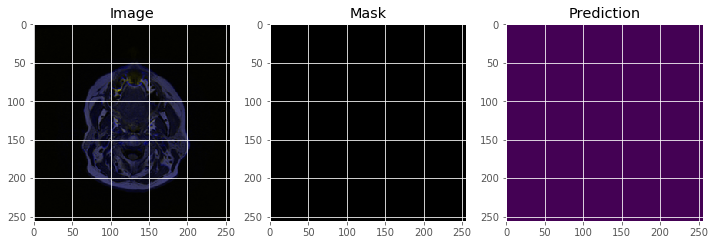

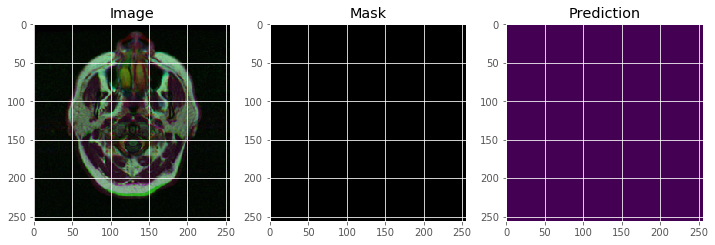

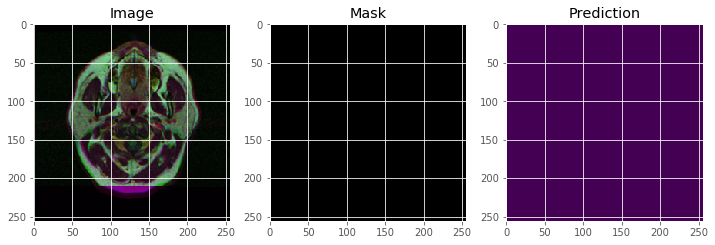

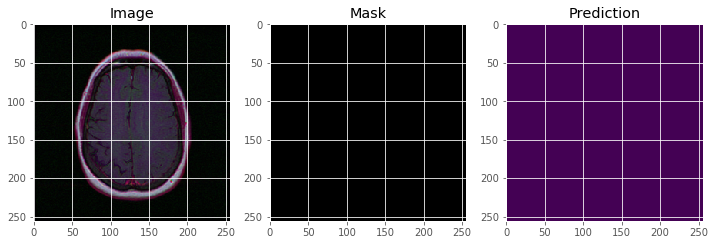

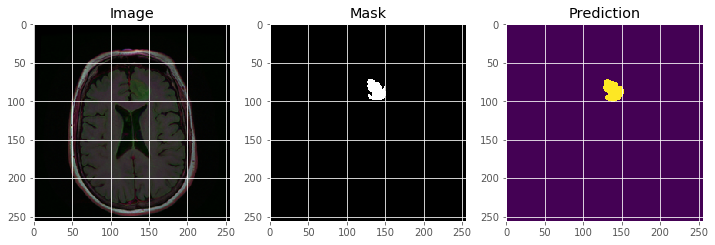

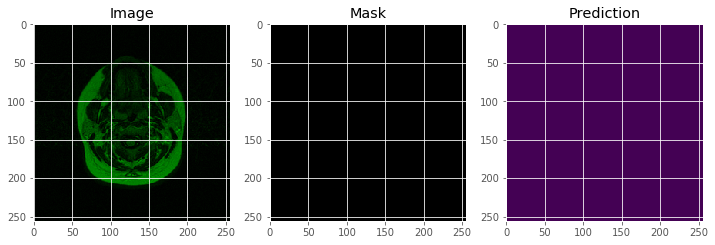

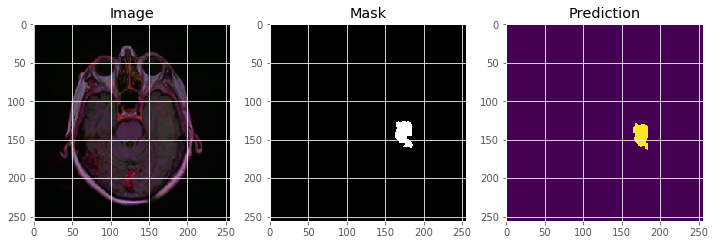

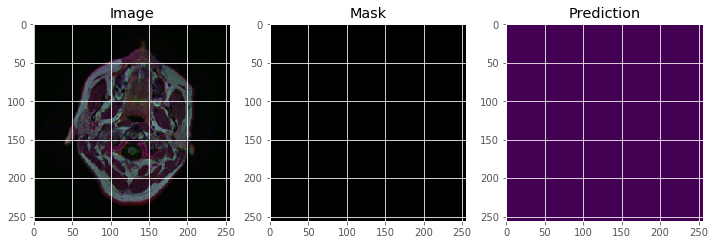

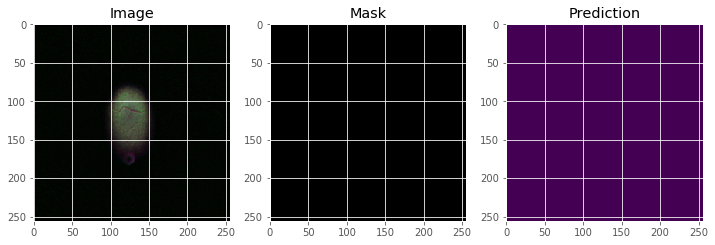

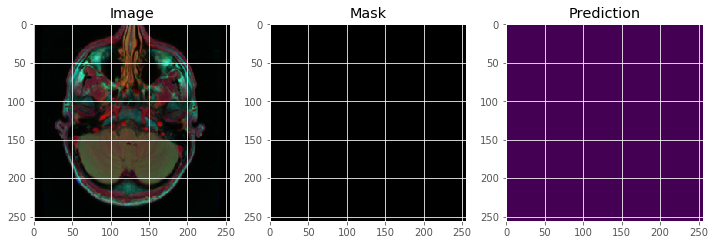

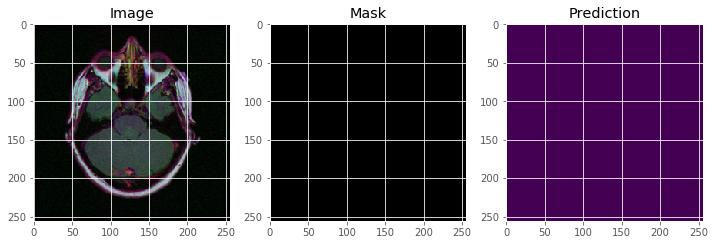

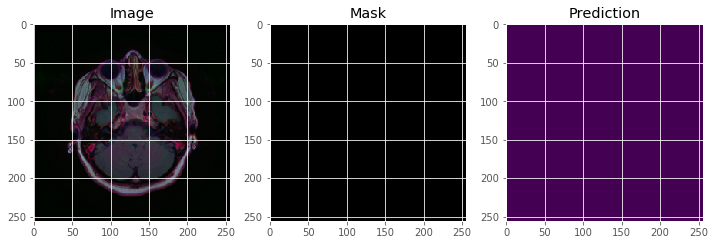

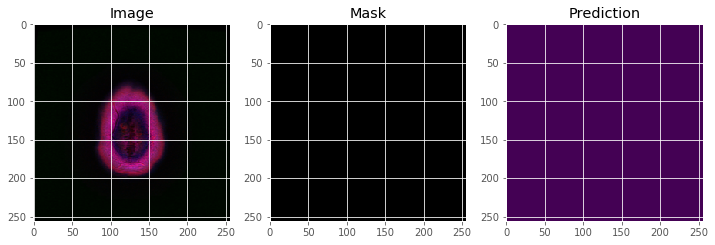

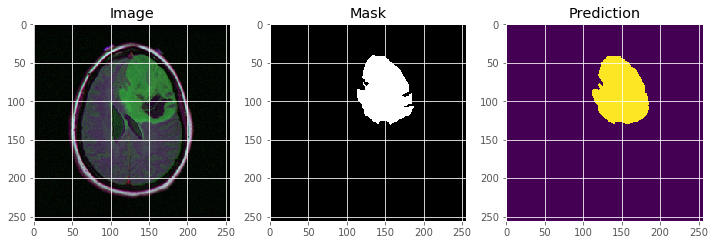

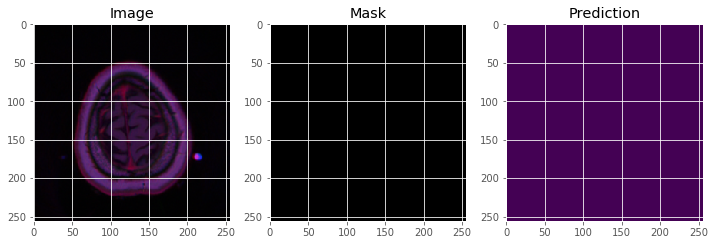

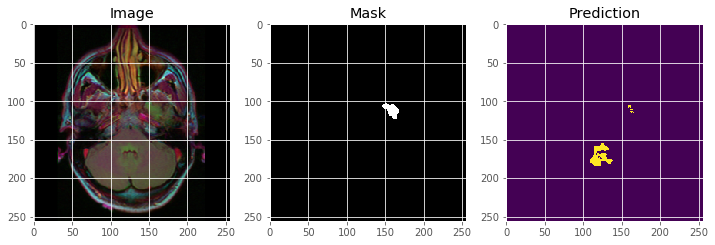

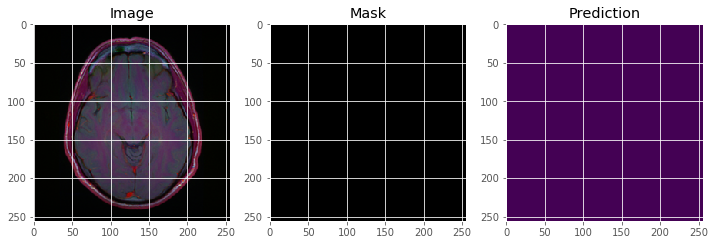

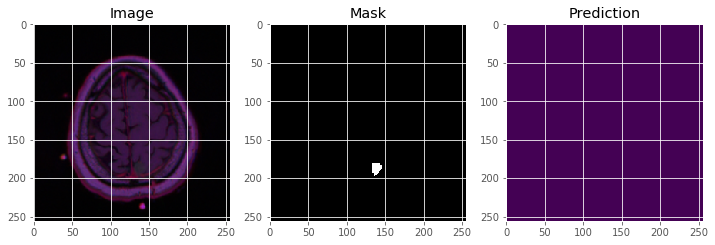

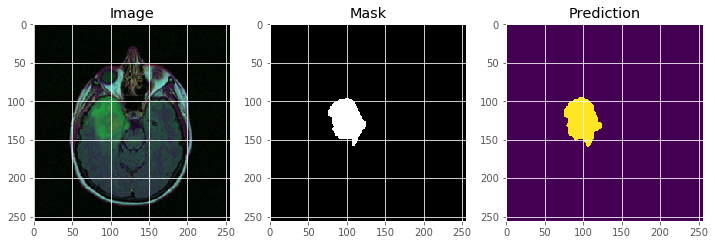

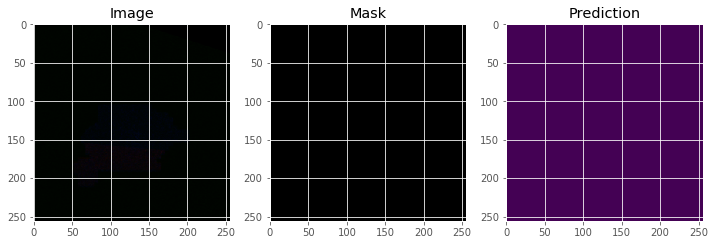

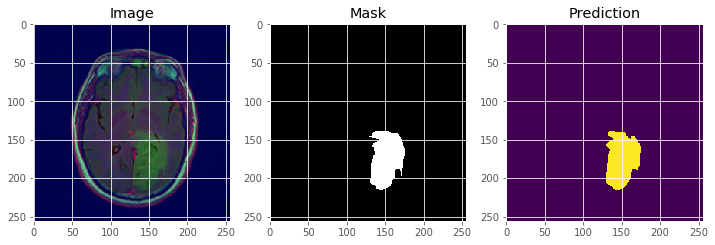

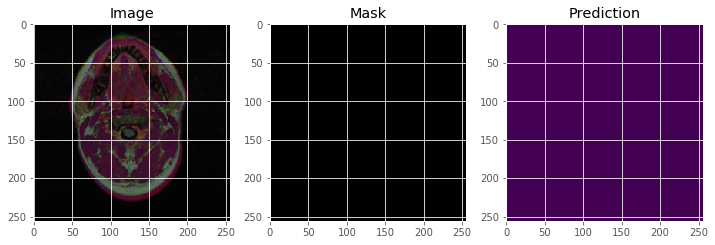

In [35]:
for i in range(30):
    index=np.random.randint(1,len(dframe_test.index))
    img = cv2.imread(dframe_test['filename'].iloc[index])
    img = cv2.resize(img ,(image_height, image_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(dframe_test['mask'].iloc[index])))
    plt.title('Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()